In [1]:
!pip install pyro-ppl

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# We use the kernels from Pyro
import torch
import pyro
import pyro.contrib.gp as gp

In [3]:
# Defining our xs and ws
l = 101
i = np.arange(1, l+1)
x = (i-1)/(l-1)
w = np.zeros(len(x))
w[0] = 1/(2*l-2)
w[-1] = 1/(2*l-2)
for i in range(1, len(w)-1):
    w[i] = 1/(l-1)

In [4]:
# Defining our kernel
pyro.clear_param_store()
rbf = gp.kernels.RBF(input_dim=1, variance=torch.tensor(1.5470), lengthscale=torch.tensor(0.3792))
periodic = gp.kernels.Periodic(input_dim=1, period=torch.tensor(0.4945), lengthscale=torch.tensor(0.7283), variance=torch.tensor(0.6971))
sum_kernel = gp.kernels.Sum(kern0=rbf, kern1=periodic)

def make_K_matrix(kernel, xs, zs):
    xs = torch.from_numpy(xs)
    zs = torch.from_numpy(zs)
    return kernel.forward(xs, zs).detach().numpy()

4.083634778202436e-09
8.356754767346875e-09
-9.837478638120845e-09
-5.5226501574981435e-09
1.0539183383211775e-08
5.000000015183674
5.0000000042321116
5.000000006804701
4.99999999427894
4.999999998067271
10.000000001627495
10.000000002444677
10.000000021781108
10.000000006663203
10.000000015118736


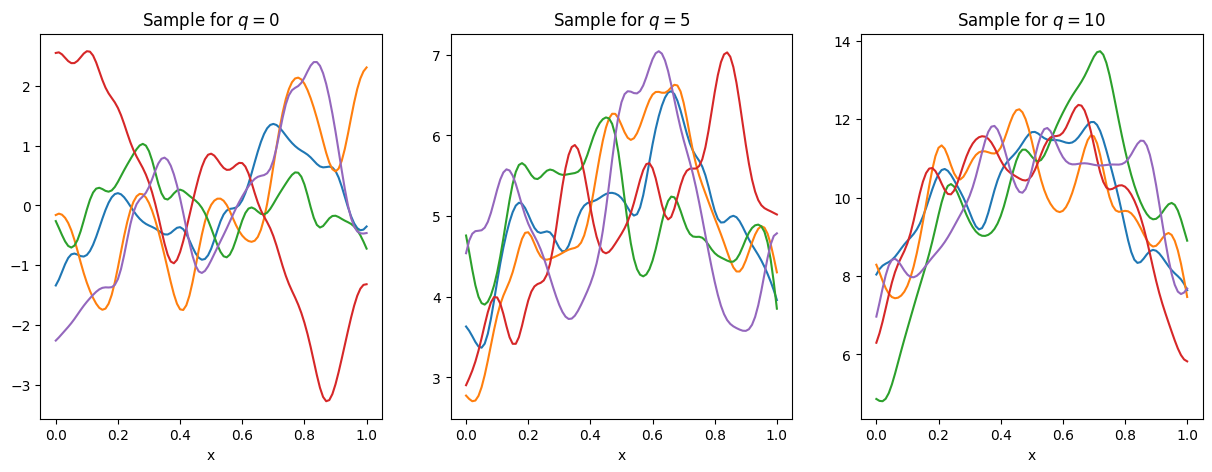

In [5]:
# Plotting of 5 samples from f | X, q
rng = np.random.default_rng(seed=67831429)
size = 5

K_X = make_K_matrix(sum_kernel, x, x)
fig, ax = plt.subplots(1, 3, figsize=(15,5))
for i, q in enumerate([0, 5, 10]):
    mu = K_X @ w / (w @ K_X @ w) * q
    Sigma = K_X - np.outer(K_X @ w / (w @ K_X @ w), K_X @ w)
    f_given_q = rng.multivariate_normal(mu, Sigma, size=size)
    ax[i].set_xlabel('x')
    ax[i].set_title(rf'Sample for $q={q}$')
    for f in f_given_q:
        ax[i].plot(x, f)
        # Sanity check: is the constrain satisfied?
        print(np.sum(f*w))
plt.savefig('B2_constrained_samples.png')

In [6]:
def g(x):
    return -np.sin(6*np.pi*x)**2 + 6*x**2 - 5*x**4 + 3/2

In [7]:
D = np.array([[0, 1.46], [0.25, 0.93], [0.5, 2.76]])
#xs = np.linspace(0, 1, 20)
#ys = g(xs) #+ np.sqrt(0.01) * np.random.randn(len(xs))
#D = np.vstack((xs, ys)).T
n = len(D)
# We add 0.05 to compensate for the wrong conditioning order
q = 2+0.05
kernel = sum_kernel
noise_y = 0.01

x_new = np.concatenate((D[:,0], x))

w_new = np.zeros(len(x_new))
w_new[0] = 1/(2*l-2)
w_new[-1] = 1/(2*l-2)
for i in range(1, len(w_new)-1):
    w_new[i] = 1/(l-1)

# (y, f*)|X
K_X = make_K_matrix(kernel, x_new, x_new)
K_X[:n, :n] += noise_y * np.identity(n)

In [8]:
# With constraint

# (y, f*)| X, q
mu_cond1 = K_X @ w_new / (w_new @ K_X @ w_new) * q
Sigma_cond1 = K_X - np.outer(K_X @ w_new / (w_new @ K_X @ w_new), K_X @ w_new)

# f* | x, q, y
mu1 = mu_cond1[:n]
mu2 = mu_cond1[n:]

Sigma11 = Sigma_cond1[:n, :n]
Sigma22 = Sigma_cond1[n:, n:]
Sigma12 = Sigma_cond1[:n, n:]
Sigma21 = Sigma_cond1[n:, :n]

mu_cond2 = mu2 + Sigma21 @ np.linalg.inv(Sigma11) @ (D[:,1] - mu1)
Sigma_cond2 = Sigma22 - Sigma21 @ np.linalg.inv(Sigma11) @ Sigma21.T

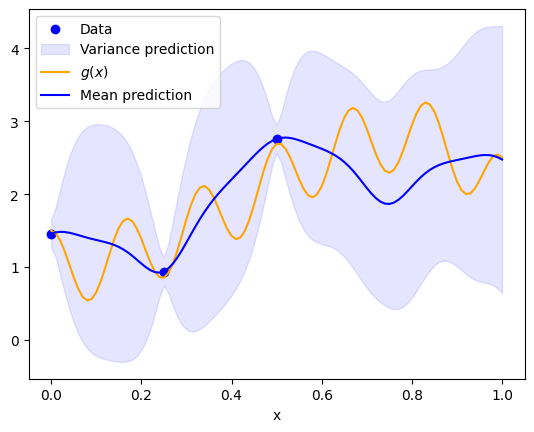

In [17]:
std_cond2 = np.sqrt(np.diag(Sigma_cond2))
plt.scatter(D[:,0], D[:,1], color='blue', label='Data')
plt.fill_between(x, mu_cond2 + 1.95 * std_cond2, mu_cond2 - 1.95 * std_cond2, color='blue', alpha=0.1, label='Variance prediction')
plt.plot(x, g(x), color="orange", label=r'$g(x)$')
plt.plot(x, mu_cond2, color='blue', label='Mean prediction')
plt.xlabel('x')
plt.legend()
plt.savefig('B2_fit_with_constraint.png')

In [11]:
# Does the mean satisfy the constrain?
np.sum(mu_cond2 * w)

1.9985045724584038

In [12]:
# g(x) does not satisfy the constraint
# so the constraint forces a too big area under the guess
np.sum(g(x)*w)

1.999933335

In [13]:
# Without constraint

Sigma11 = K_X[:n, :n]
Sigma22 = K_X[n:, n:]
Sigma12 = K_X[:n, n:]
Sigma21 = K_X[n:, :n]

mu = Sigma21 @ np.linalg.inv(Sigma11) @ D[:,1]
Sigma = Sigma22 - Sigma21 @ np.linalg.inv(Sigma11) @ Sigma21.T

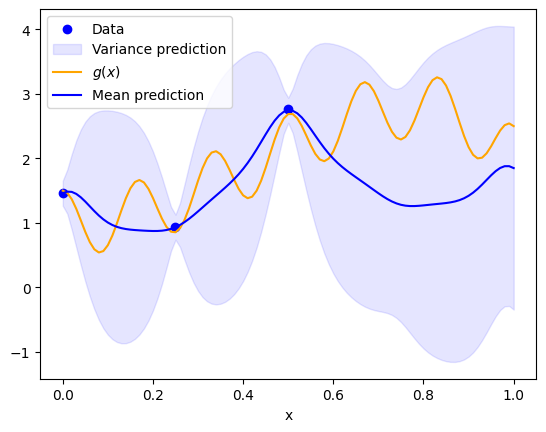

In [16]:
std = np.sqrt(np.diag(Sigma))
plt.scatter(D[:,0], D[:,1], color='blue', label='Data')
plt.fill_between(x, mu + 1.95 * std, mu - 1.95 * std, color='blue', alpha=0.1, label='Variance prediction')
plt.plot(x, g(x), color='orange', label=r'$g(x)$')
plt.plot(x, mu, color='blue', label='Mean prediction')
plt.xlabel('x')
plt.legend()
plt.savefig('B2_fit_without_constraint.png')